# Training

---

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import DoubleDDQNAgent
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Linux (x86_64), then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
print('Number of actions:', brain.vector_action_space_size)

# examine the state space
print('States look like:', env_info.vector_observations[0])
print('States have length:', len(env_info.vector_observations[0]))


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Training Preparation

In [5]:
# Environment action and state size
actionSize = brain.vector_action_space_size
stateSize = len(env_info.vector_observations[0])

# Maximum number of episode until reaching 13 reward points over 100 episodes
episodeNumber = 2000

# Epsilon settings
epsilon = 1
epsilonDecay = 0.99
epsilonMin = 0.01

# Storing episode score information
scores = []
scores_window = deque(maxlen=100)

In [6]:
# Helper functions

def updateScoreInfo(score, i_episode):
    scores.append(score)
    scores_window.append(score)
    if(i_episode % 100 == 0):
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

def IsEnvironmentSolved(i_episode):
    if np.mean(scores_window)>=13.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'banana.pth')
        return True
    return False

def getEnvStepResults(envInfo):
    nextState = envInfo.vector_observations[0]
    reward = envInfo.rewards[0]
    done = envInfo.local_done[0]
    return nextState, reward, done

def plotScoreInfo(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [7]:
def train(agent, episodeNumber = 2000, epsilon = 1.0, epsilonDecay = 0.99, epsilonMin = 0.02):

    for i_episode in range(1, episodeNumber+1):
        env_info = env.reset(train_mode=True)[brain_name]
        currentState = env_info.vector_observations[0]
        score = 0
        while(True):
            currentAction = agent.act(currentState, epsilon)
            env_info = env.step(currentAction)[brain_name]
            nextState, reward, done = getEnvStepResults(env_info)
            agent.step(currentState, currentAction, reward, nextState, done)
            currentState = nextState
            score += reward
            if(done):
                epsilon = max(epsilonMin, epsilonDecay*epsilon)
                break

        updateScoreInfo(score, i_episode)
        if(IsEnvironmentSolved(i_episode)):
            break
    return scores

Since our functions are ready, we should train the agent and examine its improvement.

Episode 100	Average Score: 0.45
Episode 200	Average Score: 3.78
Episode 300	Average Score: 8.27
Episode 400	Average Score: 12.59

Environment solved in 406 episodes!	Average Score: 13.00


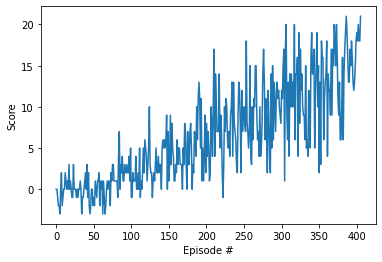

In [8]:
# Create the Double Dueling DQN agent
agent = DoubleDDQNAgent(stateSize, actionSize, seed = 0)

# Get scores in order to analise them
scores = train(agent)

# Plot scores
plotScoreInfo(scores)

We should close the environment when training is done.

In [9]:
env.close()

Training is finished. Model is saved as 'banana.pth'

Now you can try out this model by following instructions at 'Navigation_Test.ipynb' !!!